In [96]:
from IPython import display
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import omegaconf
from experiment_logger import (
    create_modquad_experiment_logger,
    log_modquad_experiment_params,
    log_modquad_environment_info,
    log_modquad_model_info,
    log_modquad_agent_info
)

import modquad_copp_env as modquad_env
import meta_learning_base as mlb
# import mbrl.env.reward_fns as reward_fns
# import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util.common as common_util
import mbrl.util as util
import modquad_utils 
import time
from models import modquad_ModelEnv
# import models. as mq_model


%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("device", device)

seed = 0
env = modquad_env.ModQuadEnv()
rng = np.random.default_rng(seed=0)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device cuda:0
Connecting to CoppeliaSim...
Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?


Get initial replay buffer. Either run simulation now or load existing flight data

In [3]:
rp_sim = env.run_gym_simulation_and_collect_data(takeoff_ht = 0.5, cut_at = 300)

start_pos:  [0.00055952 0.29986385 0.09936899]
[0.0, 0.0002797609777189791, 0.0005595219554379578, 0.0005595219554379582, -0.1863805517551102, -0.3733206254656589, -0.3733206254656582, -0.3673563356789731, -0.3613920458922874, -0.361392045892288, -0.17099643762951866, 0.019399170633249696] [0.0, 0.1499319225549698, 0.2998638451099396, 0.2998638451099396, 0.40536826947048654, 0.5108726938310335, 0.5108726938310335, 0.7597350785978607, 1.008597463364688, 1.008597463364688, 0.8767934586545318, 0.7449894539443767] [0.4, 0.5499999999999999, 0.6999999999999986, 0.7, 0.8281492305144453, 0.9562984610288909, 0.9562984610288909, 0.9793623005944991, 1.0024261401601091, 1.002426140160107, 0.9082071574834976, 0.8139881748068876]
Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?
ERROR: CANNOT SET POSITION W.R.T. -1 TO [5.59521955e-04 2.99863845e-01 7.00000000e-01]
ERROR: CANNOT SET DesiredBox ORIENTATION W.R.T. -1 TO [0. 0. 0.]
action:  [4.13867054e+00 4.11674875

KeyboardInterrupt: 

In [3]:
#to test if gym environment simulation is working
import pickle
import random 


# with open('quat_600_sim_data.pkl', 'wb') as f:
#     pickle.dump(replay_buffer_sim, f)

# with open('600_large_sim_data_dt_0.01.pkl', 'wb') as f:
#     pickle.dump(replay_buffer_sim, f)


with open('training_data/takeoff_replay_buffer_50.pkl', 'rb') as f:
    takeoff_replay_buffer = pickle.load(f)

with open('training_data/short_trajectory_replay_buffer_50.pkl', 'rb') as f:
    short_trajectory_replay_buffer = pickle.load(f)

with open('training_data/random_trajectory_replay_buffer_50.pkl', 'rb') as f:
    random_trajectory_replay_buffer = pickle.load(f)








    
# env.end_simulation()
# env.reset()

In [85]:
# Print the first element of the first 50 actions in takeoff replay buffer
print("First element of first 50 actions in takeoff replay buffer:")
for i in range(min(50, len(short_trajectory_replay_buffer))):
    obs, action, next_obs, reward, terminate, truncated = short_trajectory_replay_buffer[i]
    print(f"Action {i+1}: {action[0]}")
env.end_simulation()
env.reset()


First element of first 50 actions in takeoff replay buffer:
Action 1: -4.938585349338374
Action 2: -4.938585349338374
Action 3: 4.964181707452667
Action 4: 4.964181707452667
Action 5: 4.964181707452667
Action 6: 4.96820376831653
Action 7: 4.96820376831653
Action 8: 4.96820376831653
Action 9: 4.96820376831653
Action 10: 4.838007771350685
Action 11: 4.838007771350685
Action 12: 4.838007771350685
Action 13: 4.5483466079431265
Action 14: 4.5483466079431265
Action 15: 4.5483466079431265
Action 16: 4.2585093048896985
Action 17: 4.2585093048896985
Action 18: 4.2585093048896985
Action 19: 3.977617297962351
Action 20: 3.977617297962351
Action 21: 3.977617297962351
Action 22: 3.7108410990978506
Action 23: 3.7108410990978506
Action 24: 3.7108410990978506
Action 25: 3.7108410990978506
Action 26: 3.4613074231494987
Action 27: 3.4613074231494987
Action 28: 3.4613074231494987
Action 29: 3.2399505487953895
Action 30: 3.2399505487953895
Action 31: 3.2399505487953895
Action 32: 3.0571006246966976
Action

(array([-3.60691637e-08, -1.70620389e-08,  1.04601611e-07,  6.79286849e-09,
         1.04879405e-07,  2.00711838e-07, -8.13550650e-05, -6.94632308e-06,
         3.28326743e-04,  9.99999940e-01], dtype=float32),
 {})

In [50]:
import pickle
import random 
short_trajectory_replay_buffer = []
for i in range(50):
    
    replay_buffer_sim = env.run_gym_simulation_and_collect_short_traj_data( cut_at = 300)
    print(f"Simulation {i+1}: {len(replay_buffer_sim)} data points")
    short_trajectory_replay_buffer.extend(replay_buffer_sim)
    env.end_simulation()
    env.reset()
    


with open('training_data/short_trajectory_replay_buffer_50.pkl', 'wb') as f:
    print("Length of short trajectory replay buffer: ", len(short_trajectory_replay_buffer))
    pickle.dump(short_trajectory_replay_buffer, f)



start_pos:  [-0.86464936 -0.34025356  0.09479015]
Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?
Crash detected!
Crash detected!
Crash detected!
Crash detected!
Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?
Simulation 1: 1685 data points
Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?
start_pos:  [0.00055952 0.29986385 0.09936899]
Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?
Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?
Simulation 2: 1413 data points
Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?
start_pos:  [0.00055952 0.29986385 0.09936899]
Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?
Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?
Simulation 3: 833 data points
Conn

In [51]:
replay_buffer_sim
all_actions = []
all_obs = []
for transition in short_trajectory_replay_buffer:
    obs, action, next_obs, reward, terminate, truncated = transition
    all_obs.append(obs)
    all_actions.append(action)

all_actions = np.array(all_actions)
print("Action and observation stats for random trajectory replay buffer")
print("Number of transitions: ", len(short_trajectory_replay_buffer))


means = np.mean(all_actions, axis=0)
variances = np.var(all_actions, axis=0)
std_devs = np.std(all_actions, axis=0)
mins = np.min(all_actions, axis=0)
maxs = np.max(all_actions, axis=0)

print(" Action stats:")
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", std_devs)
print("Minimums:", mins)
print("Maximums:", maxs)

all_obs = np.array(all_obs)
print(all_obs.shape)

means = np.mean(all_obs, axis=0)
variances = np.var(all_obs, axis=0)
std_devs = np.std(all_obs, axis=0)
mins = np.min(all_obs, axis=0)
maxs = np.max(all_obs, axis=0)

print("Observation stats:")
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", std_devs)
print("Minimums:", mins)
print("Maximums:", maxs)

# pos, angles, velocity, angular_velocity

Action and observation stats for random trajectory replay buffer
Number of transitions:  59538
 Action stats:
Means: [3.24967857e+00 1.57907727e-04 1.05010591e-03 2.13607633e-02]
Variances: [0.04552245 0.00067928 0.01352939 0.0118663 ]
Standard Deviations: [0.2133599  0.02606303 0.11631592 0.10893253]
Minimums: [-4.93858535 -0.14606241 -0.38496767 -0.47911357]
Maximums: [4.96820377 0.14658726 0.38349686 0.48863104]
(59538, 10)
Observation stats:
Means: [-2.3263209e-03 -1.4300562e-03  5.3270306e-02  2.6730029e-04
  1.4015348e-03  2.3598962e-03  6.2895211e-05  6.2209438e-05
  1.0585254e-02  9.9801648e-01]
Variances: [4.3306068e-02 9.9676047e-03 5.7067212e-02 3.0852265e-03 6.1766971e-02
 4.1814731e-04 1.1328795e-04 9.9298626e-04 3.0493387e-03 4.4179691e-05]
Standard Deviations: [0.2081011  0.09983789 0.23888744 0.05554482 0.24852961 0.02044865
 0.01064368 0.03151168 0.05522082 0.00664678]
Minimums: [-0.9223473  -0.5019889  -0.50837404 -0.3271812  -1.1073885  -0.10858749
 -0.03850901 -0.10

In [6]:

combined_buffer = env.create_combined_replay_buffer(
    short_trajectory_replay_buffer=short_trajectory_replay_buffer,
    takeoff_replay_buffer=takeoff_replay_buffer,
    random_trajectory_replay_buffer=random_trajectory_replay_buffer,
    short_traj_ratio=0.4,    # 20% from short trajectory
    takeoff_ratio=0.1,       # 50% from takeoff
    random_traj_ratio=0.4    # 30% from random trajectory
)

Buffer sizes:
  Short trajectory: 59538 transitions
  Takeoff: 40363 transitions
  Random trajectory: 58736 transitions

Sampling strategy:
  Short trajectory: 23815 samples (ratio: 0.40)
  Takeoff: 4036 samples (ratio: 0.10)
  Random trajectory: 23494 samples (ratio: 0.40)
  Total combined: 51345 samples

Combined replay buffer created with 51345 total transitions


In [133]:
all_actions = []
all_obs = []
for transition in short_trajectory_replay_buffer:
    obs, action, next_obs, reward, terminate, truncated = transition
    all_obs.append(obs)
    all_actions.append(action)

all_actions = np.array(all_actions)
print("Action and observation stats for short trajectory replay buffer")
print("Number of transitions: ", len(random_trajectory_replay_buffer))


means = np.mean(all_actions, axis=0)
variances = np.var(all_actions, axis=0)
std_devs = np.std(all_actions, axis=0)
mins = np.min(all_actions, axis=0)
maxs = np.max(all_actions, axis=0)

print(" Action stats:")
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", std_devs)
print("Minimums:", mins)
print("Maximums:", maxs)

all_obs = np.array(all_obs)
print(all_obs.shape)

means = np.mean(all_obs, axis=0)
variances = np.var(all_obs, axis=0)
std_devs = np.std(all_obs, axis=0)
mins = np.min(all_obs, axis=0)
maxs = np.max(all_obs, axis=0)

print("Observation stats:")
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", std_devs)
print("Minimums:", mins)
print("Maximums:", maxs)

Action and observation stats for short trajectory replay buffer
Number of transitions:  58736
 Action stats:
Means: [3.24967857e+00 1.57907727e-04 1.05010591e-03 2.13607633e-02]
Variances: [0.04552245 0.00067928 0.01352939 0.0118663 ]
Standard Deviations: [0.2133599  0.02606303 0.11631592 0.10893253]
Minimums: [-4.93858535 -0.14606241 -0.38496767 -0.47911357]
Maximums: [4.96820377 0.14658726 0.38349686 0.48863104]
(59538, 10)
Observation stats:
Means: [-2.3263209e-03 -1.4300562e-03  5.3270306e-02  2.6730029e-04
  1.4015348e-03  2.3598962e-03  6.2895211e-05  6.2209438e-05
  1.0585254e-02  9.9801648e-01]
Variances: [4.3306068e-02 9.9676047e-03 5.7067212e-02 3.0852265e-03 6.1766971e-02
 4.1814731e-04 1.1328795e-04 9.9298626e-04 3.0493387e-03 4.4179691e-05]
Standard Deviations: [0.2081011  0.09983789 0.23888744 0.05554482 0.24852961 0.02044865
 0.01064368 0.03151168 0.05522082 0.00664678]
Minimums: [-0.9223473  -0.5019889  -0.50837404 -0.3271812  -1.1073885  -0.10858749
 -0.03850901 -0.104

In [5]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0)) # Replace 0 with the desired device index

2.4.1+cu118
True
1
0
NVIDIA GeForce RTX 3070 Laptop GPU


In [7]:
trial_length = 200
num_trials = 40
ensemble_size = 1

# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the 
# environment information
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",
        "device": device,
        "num_layers": 3,
        "ensemble_size": ensemble_size,
        "hid_size": 256,
        "in_size": "???",
        "out_size": "???",
        "deterministic": False,
        "propagation_method": "fixed_model",
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {
            "_target_": "torch.nn.LeakyReLU",
            "negative_slope": 0.01
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "dataset_size": 50000,
        "learned_rewards": False,
        "target_is_delta": True,
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 128,
        "validation_ratio": 0.1
    }
}
cfg = omegaconf.OmegaConf.create(cfg_dict)

# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)

# Create a gym-like environment to encapsulate the model
model_env = modquad_ModelEnv.modquad_ModelEnv(env, dynamics_model, enable_logging=False, generator=generator)



cuda:0
ModQuad logging disabled.


In [8]:
replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)

for tr in combined_buffer:
    obs, action, next_obs, reward, terminate, truncated = tr
    replay_buffer.add(obs, action, next_obs, reward, terminate, truncated)
print("# samples stored", replay_buffer.num_stored)

# samples stored 50000


Main experiment block 

In [9]:
env.end_simulation()
env.reset()

Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?


(array([-3.60691637e-08, -1.70620389e-08,  1.04601611e-07,  6.79286849e-09,
         1.04879405e-07,  2.00711838e-07, -8.13550650e-05, -6.94632308e-06,
         3.28326743e-04,  9.99999940e-01], dtype=float32),
 {})

In [182]:
train_losses = []
val_scores = []
train_time = []
plan_time = []


def train_callback(_model, _total_calls, _epoch, tr_loss, val_score, _best_val):
    train_losses.append(tr_loss)
    val_scores.append(val_score.mean().item())   # this returns val score per ensemble model


# Create a trainer for the model
model_trainer = models.ModelTrainer(dynamics_model, optim_lr=5e-5, weight_decay=5e-5)
if True:#trial == 0:#steps_trial == 0:
        print("Number of stored transitions: ", replay_buffer.num_stored)
        dynamics_model.update_normalizer(replay_buffer.get_all())  # update normalizer stats
        
        dataset_train, dataset_val = common_util.get_basic_buffer_iterators(
            replay_buffer,
            batch_size=cfg.overrides.model_batch_size,
            val_ratio=cfg.overrides.validation_ratio,
            ensemble_size=ensemble_size,
            shuffle_each_epoch=True,
            bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement 
        )
        print("Training model")
        training_start_time = time.time()
        model_trainer.train(
            dataset_train, 
            dataset_val=dataset_val, 
            num_epochs=50, 
            patience=50, 
            callback=train_callback,
            silent=True)
        print("training loss: ", train_losses[-1])
        print("validation loss: ", val_scores[-1])
        print("training time: ", time.time() - training_start_time)
        print("Model trained")


Number of stored transitions:  50000
Training model
training loss:  6.456117613749071
validation loss:  0.04739570617675781
training time:  131.27592492103577
Model trained


In [179]:
env.end_simulation()
env.reset()


num_trials = 40

agent_cfg = omegaconf.OmegaConf.create({
    # this class evaluates many trajectories and picks the best one
    "_target_": "mbrl.planning.TrajectoryOptimizerAgent",
    "planning_horizon":2,#was 15 initially
    "replan_freq": 2,
    "verbose": True,
    "action_lb": [0, -0.15, -0.39, -0.48],
    "action_ub": [6.488, 0.15, 0.39, 0.48], # 6.488
    # this is the optimizer to generate and choose a trajectory
    "optimizer_cfg": {
        "_target_": "mbrl.planning.CEMOptimizer",
        "num_iterations": 1,
        "elite_ratio": 0.1,
        "population_size": 30000,
        "alpha": 0.0005,
        "device": device,
        "lower_bound": [0, -0.15, -0.39, -0.48],
        "upper_bound": [6.488, 0.15, 0.39, 0.48],
        "return_mean_elites": True, #was true
        "clipped_normal": True
    }
})

agent = planning.create_trajectory_optim_agent_for_model(
    model_env,
    agent_cfg,
    num_particles=10
)


Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?


In [180]:
all_rewards = []
actions_taken = []
states = []
new_states = []
planning_times = []
ht = []
velocity = []    
action = []

def append_actions_and_states(transition):
    obs, action, next_obs, *_ = transition
    actions_in_trial.append(action)
    states_in_trial.append(obs)
    new_states.append(next_obs)


# Main PETS loop


robot_pos = env.robot.get_position()
trajectory_length, total_time, pos_traj, orient_traj = env.initialize_target_trajectory(traj = "random trajectory", 
                    start_pos=[robot_pos[0], robot_pos[1], 1.5],position_change_scale=1.5, num_hover_points=2, num_waypoints=20, time_step_duration=10)
#     trajectory parameters, default arguments used for random trajectory
    # start_pos=[0.0, 0.0, 2.0], start_yaw=0.0, 
    # start_vel=[0.0, 0.0, 0.0], start_yaw_rate=0.0,
    # position_change_scale=1.0, fixed_pos_change_dist=True,
    # orientation_change_scale=0.1,
    # std_velocity_change=0.0,
    # std_angular_velocity_change=0.0,
    # std_acceleration_change=0.0,
    # std_angular_acceleration_change=0.0,
    # num_waypoints=20, 
    # num_hover_points=3,
    # time_step_duration=20,
    # num_samples=3):
# print(trajectory_length, total_time,"\n", pos_traj[0],"\n", pos_traj[1], "\n", pos_traj[2])

model_env.set_desired_trajectory(total_time, pos_traj, orient_traj)
model_env.dt = env.dt
print(model_env.x, model_env.y, model_env.z)
print("env")
print(env.x, env.y, env.z)
# total_time *= 2
# logger._write_to_log("\nStarting main experiment loop...")

for trial in range(num_trials):
    
    print("resetting environment, and starting trial :", trial)
    agent.reset()
    env.end_simulation()
    env.reset()
    # model_env.reset()

    terminated = False
    truncated = False
    total_reward = 0.0
    steps_trial = 0

    model_env.trajectory_step = 2
    env.trajectory_step = 2
    env.update_setpoint(model_env.trajectory_step)
    time.sleep(0.5)
    obs, _ = env.reset()  
    last_setpoint_set = time.time()
    rewards_in_trial = []
    states_in_trial = []
    actions_in_trial = []
    planning_times_in_trial = []


    # update_axes(axs, env.render(), ax_text, trial, steps_trial, all_rewards)
    while not (terminated or truncated):# or (model_env.trajectory_step >= trajectory_length-1)):

        if (time.time() - last_setpoint_set > total_time/trajectory_length) :
            # env.resume_simulation()
            model_env.trajectory_step += 1
            env.trajectory_step += 1
            last_setpoint_set = time.time()
            print("setpoint updated")
            env.update_setpoint(model_env.trajectory_step)

             # LOG TRAJECTORY STEP PROGRESSION
            model_env.log_trajectory_step(model_env.trajectory_step)

            
        

            # env.pause_simulation()

        # --- Doing env step using the agent and adding to model dataset ---

        # obs is velocity, angular velocity and quat

        print("planning for trajectory step: ", model_env.trajectory_step)
        planning_start_time = time.time()

        model_env.current_pos = env.robot_position_now
        model_env.last_action_taken = env.last_action
        # model_env.current_obs = obs
        model_env.current_velocity = obs[0:3]

        new_obs, reward, terminated, truncated, _ = common_util.step_env_and_add_to_buffer(
            env, obs, agent, {}, replay_buffer, callback=append_actions_and_states)
        
        # print("planning time: ", time.time() - planning_start_time)
        print("ht:", env.robot_position_now[2], "z_vel:", new_obs[2])
        ht.append(env.z[env.trajectory_step]-env.robot_position_now[2])
        velocity.append(new_obs[2])
        action.append(env.last_action)
        planning_times_in_trial.append(time.time() - planning_start_time)
        rewards_in_trial.append(reward)
        
            
        # update_axes(
        #     axs, env.render(), ax_text, trial, steps_trial, all_rewards)
        
        obs = new_obs
        # if truncated:
        #     reward = -100
        total_reward += reward
        # states_in_trial.append(obs)
        # actions_in_trial.append(action)
        steps_trial += 1

    env.end_simulation()

    states.append(states_in_trial)
    actions_taken.append(actions_in_trial)
    planning_times.append(planning_times_in_trial)
    all_rewards.append(rewards_in_trial)
    # print(f"Trial {trial} completed: Success={success}, Waypoints={model_env.trajectory_step + 1}/{trajectory_length}")



x_shape 57
trajectory shape (57, 12)
[0.0, 0.0002797609777189791, 0.0005595219554379582, 0.0005595219554379582, 0.6414296949345897, 1.2822998679137418, 1.2822998679137414, 0.6784745852851196, 0.07464930265649539, 0.07464930265649805, -0.32865467180580227, -0.7319586462681027, -0.7319586462681025, -0.7794520223285804, -0.8269453983890587, -0.8269453983890583, -1.4709141326659319, -2.114882866942808, -2.1148828669428057, -1.427289766056924, -0.7396966651710404, -0.7396966651710419, -0.3048201580186306, 0.13005634913378028, 0.13005634913378072, 0.6659576445100972, 1.2018589398864146, 1.2018589398864135, 0.5565531963715268, -0.08875254714336211, -0.08875254714335945, 0.19728544641672519, 0.4833234399768096, 0.4833234399768098, 0.6504367707665303, 0.8175501015562499, 0.817550101556251, 0.2445054479496022, -0.3285392056570471, -0.32853920565704664, -1.015384983938783, -1.702230762220518, -1.7022307622205193, -1.1151385388683592, -0.5280463155161996, -0.5280463155161996, -0.26005131035983187,

KeyboardInterrupt: 

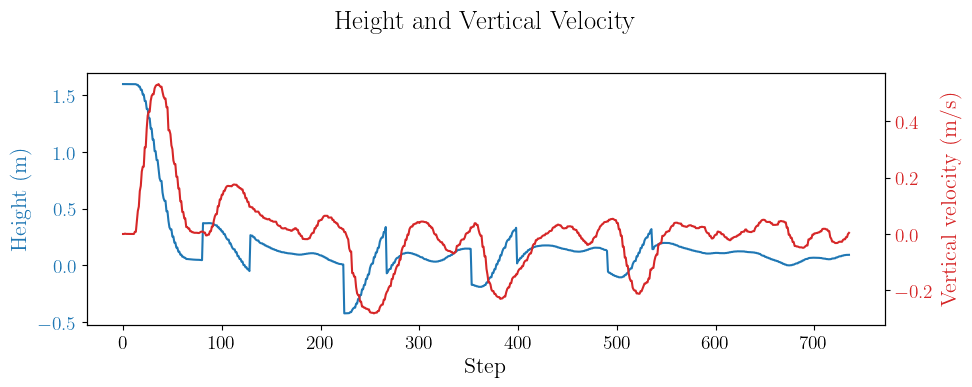

In [181]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(len(ht))

fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(t, ht, color='tab:blue', label='Height')
ax1.set_xlabel('Step')
ax1.set_ylabel('Height (m)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(t, velocity, color='tab:red', label='Vertical velocity')
ax2.set_ylabel('Vertical velocity (m/s)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.suptitle('Height and Vertical Velocity')
fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

per_trial_l2 = []
print(len(states))
print(len(actions_taken))

model = model_env.dynamics_model.model
ens = len(model.elite_models) if getattr(model, "elite_models", None) else len(model)

for i, (trial_states, trial_actions) in enumerate(zip(states, actions_taken)):
    trial_states = np.asarray(trial_states)   # (H_i+1, obs_dim)
    trial_actions = np.asarray(trial_actions) # (H_i, act_dim)
    H = min(len(trial_actions), len(trial_states) - 1)
    if H <= 0:
        per_trial_l2.append(np.array([]))
        continue

    initial_obs = trial_states[0]
    plan = trial_actions[:H]

    model_obses, _, _ = common_util.rollout_model_env(
        model_env, initial_obs, plan=plan, num_samples=ens
    )
    # model_obses: (H+1, ens, obs_dim)
    pred_obs_mean = model_obses[1:H+1].mean(axis=1)  # (H, obs_dim)
    real_obs_arr = trial_states[1:H+1]               # (H, obs_dim)

    per_step_l2 = np.linalg.norm(pred_obs_mean - real_obs_arr, axis=1)  # (H,)
    per_trial_l2.append(per_step_l2)

# Plot: one curve per trial
plt.figure(figsize=(9,4))
for i, l2 in enumerate(per_trial_l2):
    if l2.size == 0:
        continue
    plt.plot(l2, label=f"trial {i}")
plt.xlabel("Step within trial")
plt.ylabel("L2 error")
plt.grid(True)
plt.legend(ncol=2, fontsize=8)
plt.show()

12
12


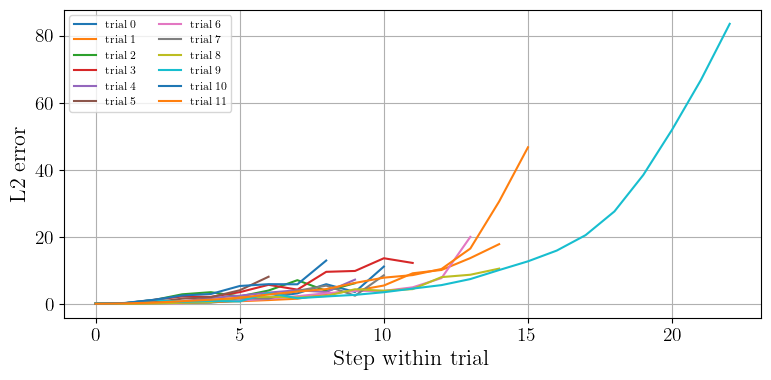

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

per_trial_l2 = []
print(len(states))
print(len(actions_taken))

model = model_env.dynamics_model.model
ens = len(model.elite_models) if getattr(model, "elite_models", None) else len(model)

for i, (trial_states, trial_actions) in enumerate(zip(states, actions_taken)):
    trial_states = np.asarray(trial_states)   # (H_i+1, obs_dim)
    trial_actions = np.asarray(trial_actions) # (H_i, act_dim)
    H = min(len(trial_actions), len(trial_states) - 1)
    if H <= 0:
        per_trial_l2.append(np.array([]))
        continue

    initial_obs = trial_states[0]
    plan = trial_actions[:H]

    model_obses, _, _ = common_util.rollout_model_env(
        model_env, initial_obs, plan=plan, num_samples=ens
    )
    # model_obses: (H+1, ens, obs_dim)
    pred_obs_mean = model_obses[1:H+1].mean(axis=1)  # (H, obs_dim)
    real_obs_arr = trial_states[1:H+1]               # (H, obs_dim)

    per_step_l2 = np.linalg.norm(pred_obs_mean - real_obs_arr, axis=1)  # (H,)
    per_trial_l2.append(per_step_l2)

# Plot: one curve per trial
plt.figure(figsize=(9,4))
for i, l2 in enumerate(per_trial_l2):
    if l2.size == 0:
        continue
    plt.plot(l2, label=f"trial {i}")
plt.xlabel("Step within trial")
plt.ylabel("L2 error")
plt.grid(True)
plt.legend(ncol=2, fontsize=8)
plt.show()

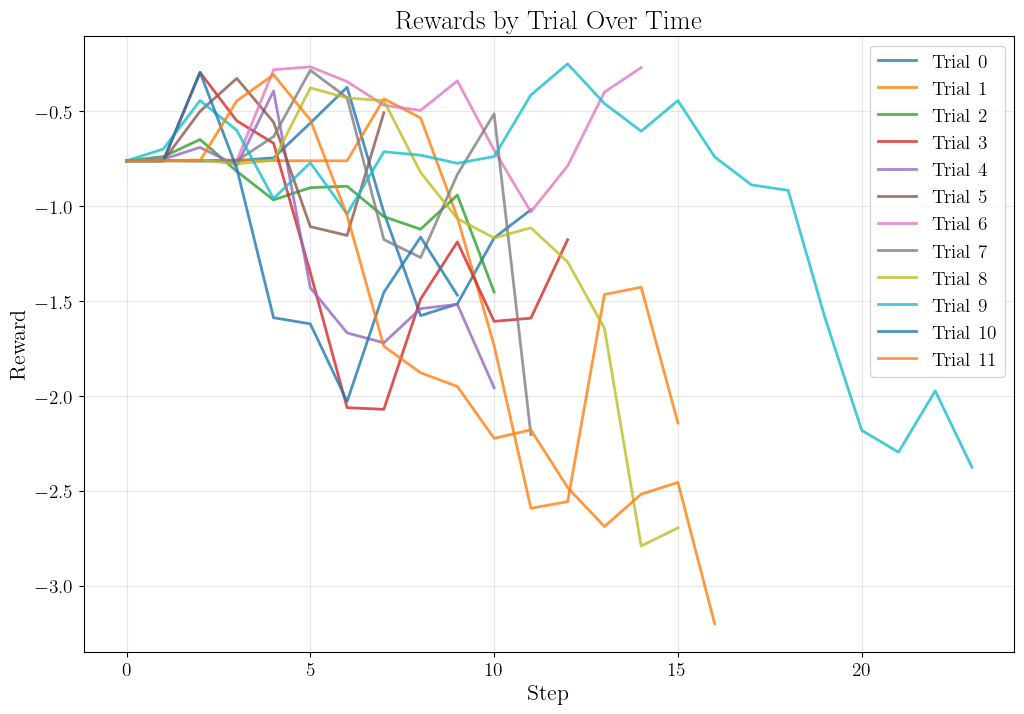

In [92]:
import matplotlib.pyplot as plt
import numpy as np


# Simplified plotting function - shows only rewards by trial over time
def plot_trial_rewards_simple(all_rewards):
    """Plot only rewards by trial over time"""
    plt.figure(figsize=(12, 8))
    
    # Plot individual trial rewards over time
    for trial_idx, rewards_in_trial in enumerate(all_rewards):
        if len(rewards_in_trial) > 0:  # Only plot if trial has rewards
            steps = np.arange(len(rewards_in_trial))
            plt.plot(steps, rewards_in_trial, alpha=0.8, label=f'Trial {trial_idx}', linewidth=2)
    
    plt.xlabel('Step')
    plt.ylabel('Reward')
    plt.title('Rewards by Trial Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Now plot just the rewards over time
plot_trial_rewards_simple(all_rewards)



In [11]:
import numpy as np
import matplotlib.pyplot as plt

# planning_times_by_trial: list of 1D arrays, each is per-step planning time for that trial
print(len(planning_times[0]))
# 1) One line per trial
plt.figure(figsize=(9,4))
for i, t in enumerate(planning_times):
    print(i, t)
    if t == 0: 
        continue
    plt.plot(t, label=f"trial {i}")
plt.xlabel("Step within trial")
plt.ylabel("Planning time (s)")
plt.grid(True)
plt.legend(ncol=2, fontsize=8)
plt.show()

# 2) Aggregate: mean ± std across trials vs step (handles different lengths)
max_len = max((len(t) for t in planning_times), default=0)
if max_len > 0:
    M = np.full((len(planning_times), max_len), np.nan, dtype=float)
    for i, t in enumerate(planning_times):
        M[i, :len(t)] = t
    mean_t = np.nanmean(M, axis=0)
    std_t = np.nanstd(M, axis=0)

    x = np.arange(max_len)
    plt.figure(figsize=(9,4))
    plt.plot(x, mean_t, label="mean planning time")
    plt.fill_between(x, mean_t - std_t, mean_t + std_t, color="C0", alpha=0.2, label="±1 std")
    plt.xlabel("Step within trial")
    plt.ylabel("Planning time (s)")
    plt.grid(True)
    plt.legend()
    plt.show()

126
0 [0.06879043579101562, 0.01293802261352539, 0.06677699089050293, 0.011924028396606445, 0.07277750968933105, 0.011569738388061523, 0.07241249084472656, 0.013285636901855469, 0.06641674041748047, 0.01187586784362793, 0.07269978523254395, 0.0121612548828125, 0.07511425018310547, 0.015966176986694336, 0.06649303436279297, 0.01228475570678711, 0.07286739349365234, 0.011953353881835938, 0.07239508628845215, 0.018464326858520508, 0.06670403480529785, 0.012708663940429688, 0.07206845283508301, 0.01225733757019043, 0.06649613380432129, 0.018175601959228516, 0.0668032169342041, 0.011205434799194336, 0.07954144477844238, 0.012220382690429688, 0.06660819053649902, 0.012042045593261719, 0.06684637069702148, 0.011178731918334961, 0.07355904579162598, 0.01222372055053711, 0.06580734252929688, 0.01903080940246582, 0.07916927337646484, 0.01640939712524414, 0.0777125358581543, 0.01599407196044922, 0.07762527465820312, 0.013996601104736328, 0.07871413230895996, 0.015001535415649414, 0.07800149917602

KeyboardInterrupt: 

1
Results will be saved to: planner_results\20250819_121400_cem_iter1_pop20000_elite0.1


c:\Users\ksubh\anaconda3\envs\mquad_cuda\lib\site-packages\numpy\linalg\linalg.py:2541: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
c:\Users\ksubh\anaconda3\envs\mquad_cuda\lib\site-packages\numpy\linalg\linalg.py:2542: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


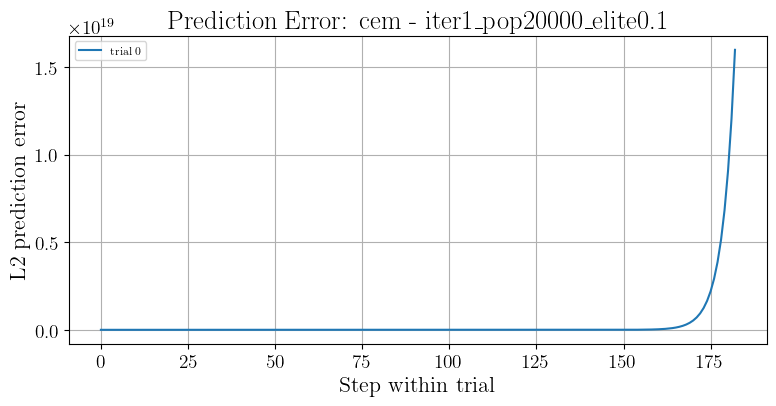

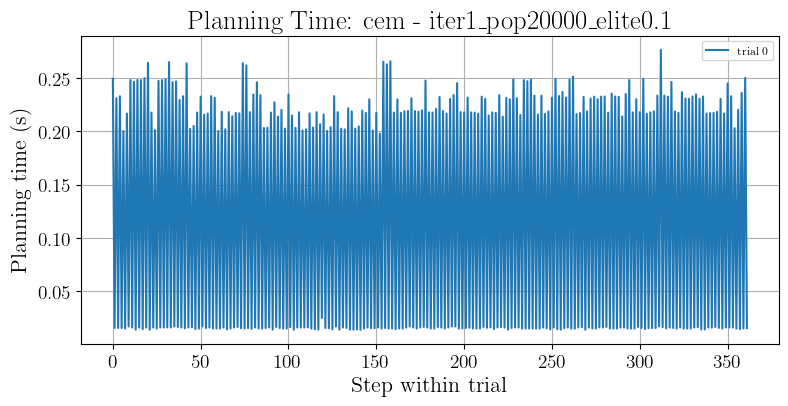

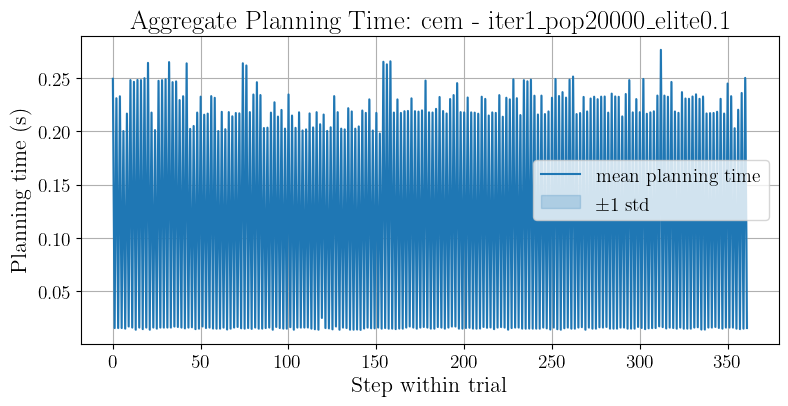

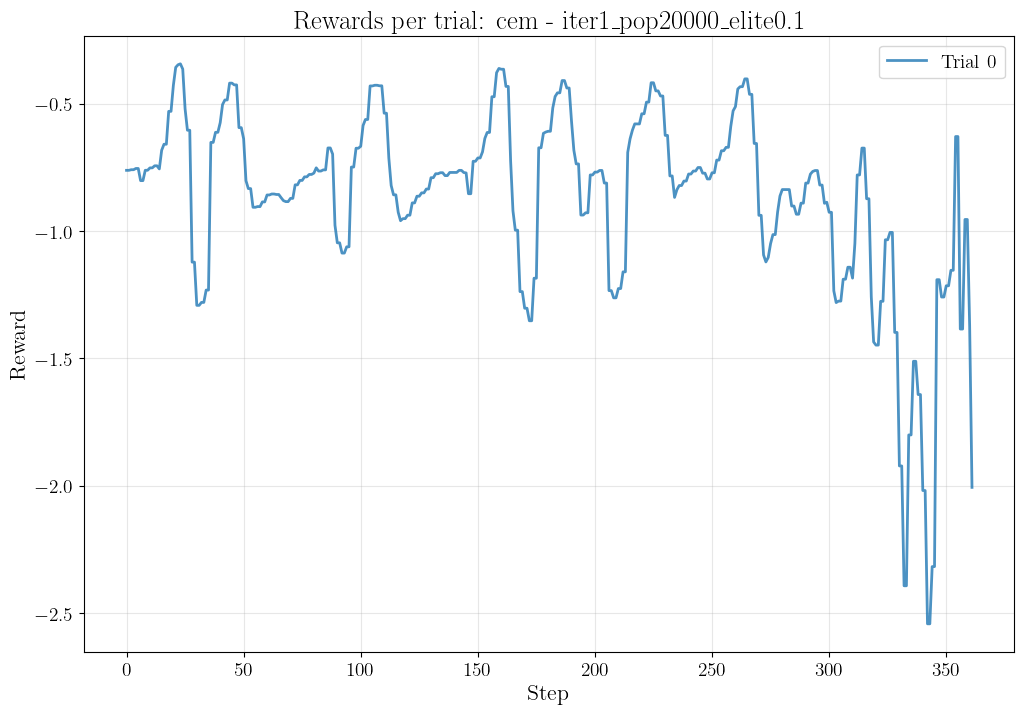

All plots saved!


In [ ]:
# All plots
# Cell 1: Create output directory and save config
import os
import pathlib
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
planner_name = "cem"  # or "icem", "mppi"
config_str = f"iter{agent_cfg.optimizer_cfg.num_iterations}_pop{agent_cfg.optimizer_cfg.population_size}_elite{agent_cfg.optimizer_cfg.elite_ratio}"
output_dir = pathlib.Path(f"planner_results/{timestamp}_{planner_name}_{config_str}")
output_dir.mkdir(parents=True, exist_ok=True)

print(agent_cfg.optimizer_cfg.num_iterations)
# Save experiment configuration
with open(output_dir / "experiment_config.txt", "w") as f:
    f.write(f"Experiment Configuration\n")
    f.write(f"=======================\n\n")
    f.write(f"Planner: {planner_name}\n")
    f.write(f"Num iterations: {agent_cfg.optimizer_cfg.num_iterations}\n")
    f.write(f"Population size: {agent_cfg.optimizer_cfg.population_size}\n")
    f.write(f"Elite ratio: {agent_cfg.optimizer_cfg.elite_ratio}\n")
    f.write(f"Planning horizon: {agent_cfg.planning_horizon}\n")
    f.write(f"Replan frequency: {agent_cfg.replan_freq}\n")
    f.write(f"Ensemble size: {ensemble_size}\n")
    f.write(f"Num trials: {num_trials}\n")
    f.write(f"Model batch size: {cfg.overrides.model_batch_size}\n")
    f.write(f"Validation ratio: {cfg.overrides.validation_ratio}\n")
    f.write(f"Timestamp: {timestamp}\n")

print(f"Results will be saved to: {output_dir}")


import numpy as np
import matplotlib.pyplot as plt

# Plot 1: L2 prediction error per trial
per_trial_l2 = []
model = model_env.dynamics_model.model
ens = len(model.elite_models) if getattr(model, "elite_models", None) else len(model)

for i, (trial_states, trial_actions) in enumerate(zip(states, actions_taken)):
    trial_states = np.asarray(trial_states)
    trial_actions = np.asarray(trial_actions)
    H = min(len(trial_actions), len(trial_states) - 1)
    if H <= 0:
        per_trial_l2.append(np.array([]))
        continue

    initial_obs = trial_states[0]
    plan = trial_actions[:H]

    model_obses, _, _ = common_util.rollout_model_env(
        model_env, initial_obs, plan=plan, num_samples=ens
    )
    pred_obs_mean = model_obses[1:H+1].mean(axis=1)
    real_obs_arr = trial_states[1:H+1]

    per_step_l2 = np.linalg.norm(pred_obs_mean - real_obs_arr, axis=1)
    per_trial_l2.append(per_step_l2)

# Save Plot 1
plt.figure(figsize=(9,4))
for i, l2 in enumerate(per_trial_l2):
    if l2.size == 0: continue
    plt.plot(l2, label=f"trial {i}")
plt.xlabel("Step within trial")
plt.ylabel("L2 prediction error")
plt.grid(True)
plt.legend(ncol=2, fontsize=8)
plt.title(f"Prediction Error: {planner_name} - {config_str}")
plt.savefig(output_dir / "01_prediction_error_per_trial.png", dpi=150, bbox_inches="tight")
plt.show()

# Plot 2: Planning time per trial
plt.figure(figsize=(9,4))
for i, t in enumerate(planning_times):
    if len(t) == 0: continue
    plt.plot(t, label=f"trial {i}")
plt.xlabel("Step within trial")
plt.ylabel("Planning time (s)")
plt.grid(True)
plt.legend(ncol=2, fontsize=8)
plt.title(f"Planning Time: {planner_name} - {config_str}")
plt.savefig(output_dir / "02_planning_time_per_trial.png", dpi=150, bbox_inches="tight")
plt.show()

# Plot 3: Aggregate planning time (mean ± std)
max_len = max((len(t) for t in planning_times), default=0)
if max_len > 0:
    M = np.full((len(planning_times), max_len), np.nan, dtype=float)
    for i, t in enumerate(planning_times):
        M[i, :len(t)] = t
    mean_t = np.nanmean(M, axis=0)
    std_t = np.nanstd(M, axis=0)

    x = np.arange(max_len)
    plt.figure(figsize=(9,4))
    plt.plot(x, mean_t, label="mean planning time")
    plt.fill_between(x, mean_t - std_t, mean_t + std_t, color="C0", alpha=0.2, label="±1 std")
    plt.xlabel("Step within trial")
    plt.ylabel("Planning time (s)")
    plt.grid(True)
    plt.legend()
    plt.title(f"Aggregate Planning Time: {planner_name} - {config_str}")
    plt.savefig(output_dir / "03_aggregate_planning_time.png", dpi=150, bbox_inches="tight")
    plt.show()



# Simplified plotting function - shows only rewards by trial over time
def plot_trial_rewards_simple(all_rewards):
    """Plot only rewards by trial over time"""
    plt.figure(figsize=(12, 8))
    
    # Plot individual trial rewards over time
    for trial_idx, rewards_in_trial in enumerate(all_rewards):
        if len(rewards_in_trial) > 0:  # Only plot if trial has rewards
            steps = np.arange(len(rewards_in_trial))
            plt.plot(steps, rewards_in_trial, alpha=0.8, label=f'Trial {trial_idx}', linewidth=2)
    
    plt.xlabel('Step')
    plt.ylabel('Reward')
    plt.title('Rewards by Trial Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title(f"Rewards per trial: {planner_name} - {config_str}")
    plt.savefig(output_dir / "04_rewards_per_trial.png", dpi=150, bbox_inches="tight")
    plt.show()

# Now plot just the rewards over time
plot_trial_rewards_simple(all_rewards)
print("All plots saved!")
